In [3]:
import numpy as np
from pickle import load
from votekit.utils import mentions
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from src.viz import viz_order
from src.markov import gen_mentions_partition, random_partition, naive_proposal, tilted_run
from src.scores import combined_score, cut_score, relative_size_score
from src.cleaning import Portland_clean
from functools import partial


In [4]:

with open('./data/Portland_D1.pkl', 'rb') as file:
    loaded = load(file)
boost = loaded['boost']
profile = Portland_clean(loaded['profile'])
print(profile.candidates)
candidates = loaded['candidates']
#viz_order(candidates, candidates, boost)gen_mentions_partition

712.0 ballots, or 1.6% of all ballots, were spoiled by overvotes or skips in D1.
86.0 ballots, or 0.2% of all ballots, were scrubbed by write ins in D1.
('Timur Ender', 'Michael (Mike) Sands', 'David Linn', 'Joe Allen', 'Joe Furi', 'Thomas Shervey', 'Terrence Hayes', 'Deian Salazar', 'Cayle Tern', 'Candace Avalos', 'Noah Ernst', 'Jamie Dunphy', 'Doug Clove', 'Uncertified Write In', 'Loretta Smith', 'Steph Routh', 'Peggy Sue Owens')


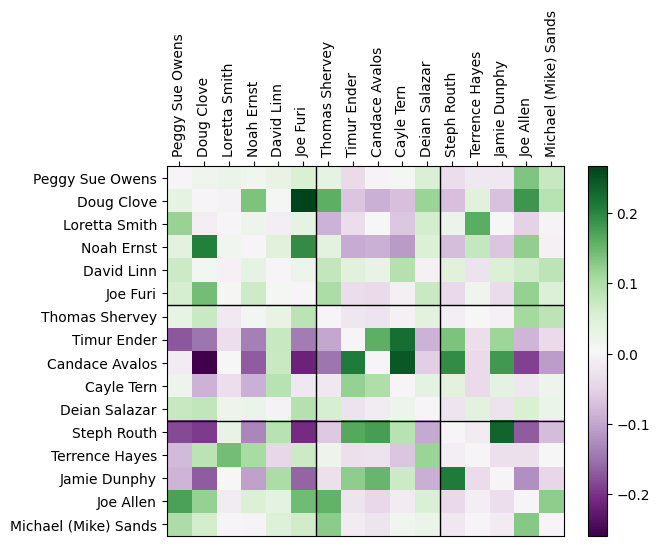

308670.62205685757
309033.28032194666


In [5]:
starting_partition = random_partition(candidates, 3)
mentions_partition = gen_mentions_partition(profile, candidates, 3)
viz_order(candidates, starting_partition, boost)
print(combined_score(profile, starting_partition))
print(combined_score(profile, mentions_partition))

In [6]:
print(cut_score(profile, starting_partition), 10000*relative_size_score(profile, starting_partition))

183436.0 125234.62205685755


In [9]:
best = tilted_run(profile, starting_partition, partial(combined_score,alpha = 1, beta = 100000), iterations =1000)

In [10]:
combined_score(profile, best)

np.float64(295837.1778169994)

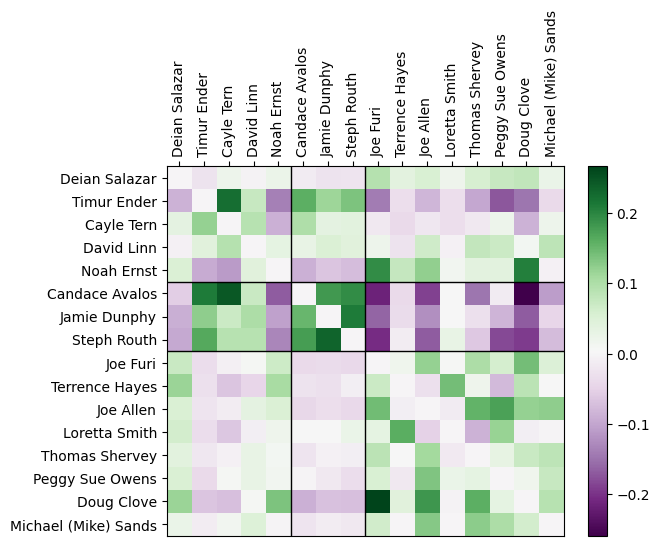

In [11]:
viz_order(candidates, best, boost)

In [12]:
starting_partition = random_partition(candidates, 2)
best2k=tilted_run(profile, starting_partition, partial(combined_score,alpha = 1, beta = 100000), iterations = 1000)

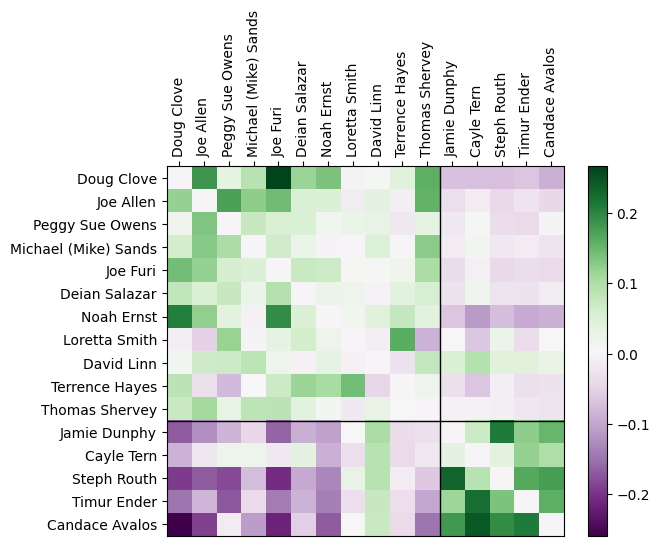

In [13]:
viz_order(candidates, best2k, boost)

In [16]:
cut_score(profile, best2k), 100000*relative_size_score(profile, best2k)

(np.float64(106500.0), 280595.7655372428)

In [20]:
cut_score(profile, flip_Linn), 100000*relative_size_score(profile, flip_Linn)

(np.float64(107634.0), 282185.5491414984)

In [19]:
flip_Linn = [['Doug Clove',
  'Joe Allen',
  'Peggy Sue Owens',
  'Michael (Mike) Sands',
  'Joe Furi',
  'Deian Salazar',
  'Noah Ernst',
  'Loretta Smith',
  'Terrence Hayes',
  'Thomas Shervey'],
 ['Jamie Dunphy',
  'Cayle Tern',
  'Steph Routh',
  'David Linn',
  'Timur Ender',
  'Candace Avalos']]